# Optional Lab: Logistic Regression

In this ungraded lab, you will 
- explore the sigmoid function (also known as the logistic function)
- explore logistic regression; which uses the sigmoid function

In [6]:
import sys, os
import numpy as np

import matplotlib.pyplot as plt
from pathlib import Path

def running_in_colab() -> bool:
    try:
        import google.colab  # 只有在 Colab 才存在
        return True
    except Exception:
        return False

def import_data_from_github():
    import os, urllib.request, pathlib, shutil

    # 1) 乾淨化 /content/utils
    UTILS_DIR = "/content/utils"
    REPO_DIR = "Machine-Learning-Lab"

    shutil.rmtree(UTILS_DIR, ignore_errors=True)

    os.makedirs("/content/utils", exist_ok=True)
    pathlib.Path("/content/utils/__init__.py").touch()  # 保險

    BASE = f"https://raw.githubusercontent.com/mz038197/{REPO_DIR}/main"
    urllib.request.urlretrieve(f"{BASE}/utils/lab_utils_common_classification.py", "/content/utils/lab_utils_common_classification.py")
    urllib.request.urlretrieve(f"{BASE}/utils/plt_one_addpt_onclick.py", "/content/utils/plt_one_addpt_onclick.py")
    urllib.request.urlretrieve(f"{BASE}/utils/deeplearning.mplstyle", "/content/utils/deeplearning.mplstyle")

    # 讓 Python 能找到 /content 下面的 utils
    if "/content" not in sys.path:
        sys.path.insert(0, "/content")

if running_in_colab(): import_data_from_github()


def find_repo_root(marker="utils"):
    cur = Path.cwd()
    while cur != cur.parent:  # 防止無限迴圈，到達檔案系統根目錄就停
        if (cur / marker).exists():
            return cur
        cur = cur.parent
    raise FileNotFoundError(f"找不到包含 {marker} 的專案根目錄")

repo_root = find_repo_root()
os.chdir(repo_root)
sys.path.append(str(repo_root)) if str(repo_root) not in sys.path else None
print(f"工作目錄已切換到 {Path.cwd()} 且加入到系統路徑")

from utils.lab_utils_common_classification import draw_vthresh
from utils.plt_one_addpt_onclick import plt_one_addpt_onclick

plt.style.use('utils/deeplearning.mplstyle')
print("匯入模組及設定繪圖樣式完成!")

工作目錄已切換到 d:\Work\Python\Machine-Learning-Lab 且加入到系統路徑
匯入模組及設定繪圖樣式完成!


## Sigmoid or Logistic Function
<img align="left" src="./images/C1_W3_LogisticRegression_left.png"     style=" width:300px; padding: 10px; " >As discussed in the lecture videos, for a classification task, we can start by using our linear regression model, $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot  \mathbf{x}^{(i)} + b$, to predict $y$ given $x$. 
- However, we would like the predictions of our classification model to be between 0 and 1 since our output variable $y$ is either 0 or 1. 
- This can be accomplished by using a "sigmoid function" which maps all input values to values between 0 and 1. 


Let's implement the sigmoid function and see this for ourselves.

## Formula for Sigmoid function

The formula for a sigmoid function is as follows -  

$g(z) = \frac{1}{1+e^{-z}}\tag{1}$

In the case of logistic regression, z (the input to the sigmoid function), is the output of a linear regression model. 
- In the case of a single example, $z$ is scalar.
- in the case of multiple examples, $z$ may be a vector consisting of $m$ values, one for each example. 
- The implementation of the sigmoid function should cover both of these potential input formats.
Let's implement this in Python.

NumPy has a function called [`exp()`](https://numpy.org/doc/stable/reference/generated/numpy.exp.html), which offers a convenient way to calculate the exponential ( $e^{z}$) of all elements in the input array (`z`).
 
It also works with a single number as an input, as shown below.

In [2]:
# Input is an array. 
input_array = np.array([1,2,3])
exp_array = np.exp(input_array)

print("Input to exp:", input_array)
print("Output of exp:", exp_array)

# Input is a single number
input_val = 1  
exp_val = np.exp(input_val)

print("Input to exp:", input_val)
print("Output of exp:", exp_val)

Input to exp: [1 2 3]
Output of exp: [ 2.72  7.39 20.09]
Input to exp: 1
Output of exp: 2.718281828459045


The `sigmoid` function is implemented in python as shown in the cell below.

In [3]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
         
    """

    g = 1/(1+np.exp(-z))
   
    return g

Let's see what the output of this function is for various value of `z`

In [4]:
# Generate an array of evenly spaced values between -10 and 10
z_tmp = np.arange(-10,11)

# Use the function implemented above to get the sigmoid values
y = sigmoid(z_tmp)

# Code for pretty printing the two arrays next to each other
np.set_printoptions(precision=3) 
print("Input (z), Output (sigmoid(z))")
print(np.c_[z_tmp, y])

Input (z), Output (sigmoid(z))
[[-1.000e+01  4.540e-05]
 [-9.000e+00  1.234e-04]
 [-8.000e+00  3.354e-04]
 [-7.000e+00  9.111e-04]
 [-6.000e+00  2.473e-03]
 [-5.000e+00  6.693e-03]
 [-4.000e+00  1.799e-02]
 [-3.000e+00  4.743e-02]
 [-2.000e+00  1.192e-01]
 [-1.000e+00  2.689e-01]
 [ 0.000e+00  5.000e-01]
 [ 1.000e+00  7.311e-01]
 [ 2.000e+00  8.808e-01]
 [ 3.000e+00  9.526e-01]
 [ 4.000e+00  9.820e-01]
 [ 5.000e+00  9.933e-01]
 [ 6.000e+00  9.975e-01]
 [ 7.000e+00  9.991e-01]
 [ 8.000e+00  9.997e-01]
 [ 9.000e+00  9.999e-01]
 [ 1.000e+01  1.000e+00]]


The values in the left column are `z`, and the values in the right column are `sigmoid(z)`. As you can see, the input values to the sigmoid range from -10 to 10, and the output values range from 0 to 1. 

Now, let's try to plot this function using the `matplotlib` library.

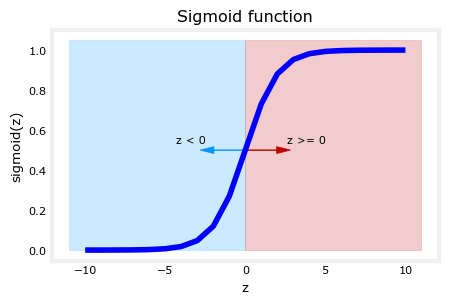

In [7]:
# Plot z vs sigmoid(z)
fig,ax = plt.subplots(1,1,figsize=(5,3))
ax.plot(z_tmp, y, c="b")

ax.set_title("Sigmoid function")
ax.set_ylabel('sigmoid(z)')
ax.set_xlabel('z')
draw_vthresh(ax,0)

As you can see, the sigmoid function approaches  `0` as `z` goes to large negative values and approaches `1` as `z` goes to large positive values.


## Logistic Regression
<img align="left" src="./images/C1_W3_LogisticRegression_right.png"     style=" width:300px; padding: 10px; " > A logistic regression model applies the sigmoid to the familiar linear regression model as shown below:

$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(\mathbf{w} \cdot \mathbf{x}^{(i)} + b ) \tag{2} $$ 

  where

  $g(z) = \frac{1}{1+e^{-z}}\tag{3}$


  
Let's apply logistic regression to the categorical data example of tumor classification.  
First, load the examples and initial values for the parameters.
  


In [8]:
x_train = np.array([0., 1, 2, 3, 4, 5])
y_train = np.array([0,  0, 0, 1, 1, 1])

w_in = np.zeros((1))
b_in = 0

Try the following steps:
- Click on 'Run Logistic Regression' to find the best logistic regression model for the given training data
    - Note the resulting model fits the data quite well.
    - Note, the orange line is '$z$' or $\mathbf{w} \cdot \mathbf{x}^{(i)} + b$  above. It does not match the line in a linear regression model.
Further improve these results by applying a *threshold*. 
- Tick the box on the 'Toggle 0.5 threshold' to show the predictions if a threshold is applied.
    - These predictions look good. The predictions match the data
    - Now, add further data points in the large tumor size range (near 10), and re-run logistic regression.
    - unlike the linear regression model, this model continues to make correct predictions

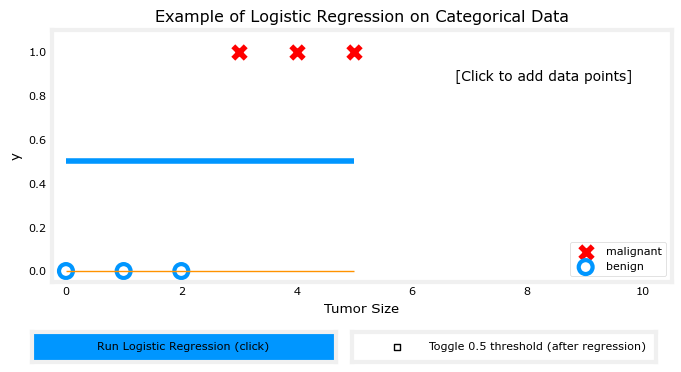

In [9]:
plt.close('all') 
addpt = plt_one_addpt_onclick( x_train,y_train, w_in, b_in, logistic=True)

## Congratulations!
You have explored the use of the sigmoid function in logistic regression.